# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, neighbors
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

%matplotlib inline

In [2]:
# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

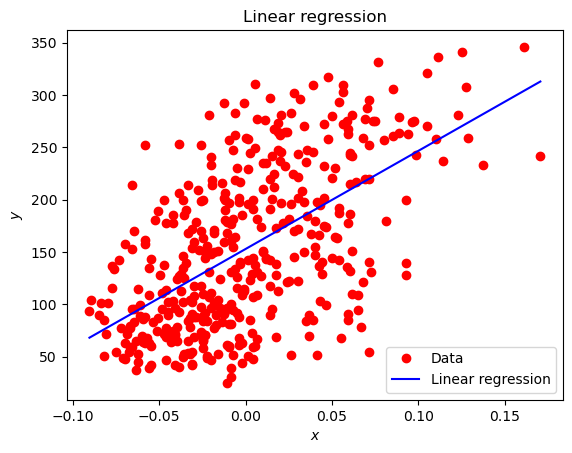

In [3]:
fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [4]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [5]:
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [7]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

*source: https://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/*

Let $\hat{\theta}$ be the estimate of a parameter $\theta$, and let the true parameter be $\theta$. The mean squared error (MSE) of the estimator $\hat{\theta}$ is given by:

$$
\text{MSE} = \mathbb{E}[(\hat{\theta} - \theta)^2]
$$

This is the expected squared difference between the estimate and the true parameter. The aim is to decompose this into bias and variance terms.

### Step 1: Add and subtract the expected value of the estimate

Then, by adding and subtracting the expected value of the estimator $\mathbb{E}[\hat{\theta}]$ inside the squared term:

$$
\text{MSE} = \mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}] + \mathbb{E}[\hat{\theta}] - \theta)^2]
$$

### Step 2: Expand the square

Next, expand the square:

$$
\text{MSE} = \mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])^2 + 2(\hat{\theta} - \mathbb{E}[\hat{\theta}])(\mathbb{E}[\hat{\theta}] - \theta) + (\mathbb{E}[\hat{\theta}] - \theta)^2]
$$

### Step 3: Simplify the terms

We can simplify this expression term by term.

- The first term, $\mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])^2]$, is the **variance** of the estimator $\hat{\theta}$, denoted by $\text{Var}(\hat{\theta})$.
  
$$
\mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])^2] = \text{Var}(\hat{\theta})
$$

- The second term, $2 \mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])(\mathbb{E}[\hat{\theta}] - \theta)]$, is zero because $\hat{\theta} - \mathbb{E}[\hat{\theta}]$ has zero expectation (by the definition of expectation).

$$
\mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])(\mathbb{E}[\hat{\theta}] - \theta)] = 0
$$

- The third term, $\mathbb{E}[(\mathbb{E}[\hat{\theta}] - \theta)^2]$, is the **bias** squared of the estimator, denoted by $\text{Bias}(\hat{\theta})^2$.

$$
(\mathbb{E}[\hat{\theta}] - \theta)^2 = \text{Bias}(\hat{\theta})^2
$$

### Step 4: Final decomposition

Substituting these results back into the expression for the MSE, we get the bias-variance decomposition:

$$
\text{MSE} = \text{Var}(\hat{\theta}) + \text{Bias}(\hat{\theta})^2
$$

Thus, the mean squared error (MSE) can be decomposed into two components:
- **Variance**: Measures how much the estimate $\hat{\theta}$ varies around its expected value.
- **Bias**: Measures the squared difference between the expected estimate $\mathbb{E}[\hat{\theta}]$ and the true parameter $\theta$.

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

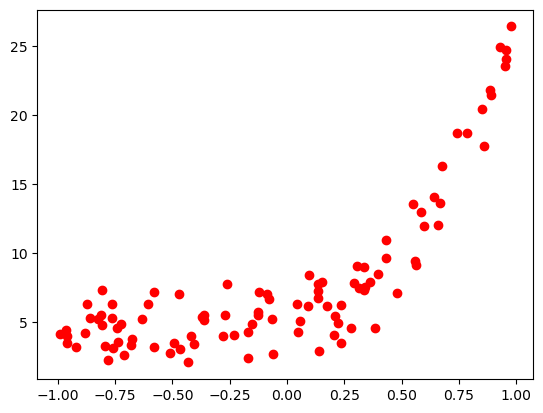

In [8]:
def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

# Add a dimension to X and y
X = X[:, np.newaxis]
y = y[:, np.newaxis]

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

In logistic regression, models with high bias are those that are too simple and underfit the data, while models with high variance are those that are too complex and overfit the data. In this case, the models with a lower polynomial order (from the figure, only the 1st order model) have high bias and show underfitting, while models with a higher polynomial order (4th order and higher) are prone to overfitting. The key is to find a balance between bias and variance to achieve good generalization performance. Regularization and feature selection are important techniques to manage this tradeoff. Additionally, the elbow method is often used to find the sweet spot for the optimal polynomial order, as it shows the smallest polynomial order that has low variance.

Best parameters: {'poly__degree': 3}
Best cross-validation score (negative MSE): -2.384153441573212
Test set mean squared error (MSE): 3.213966714701594


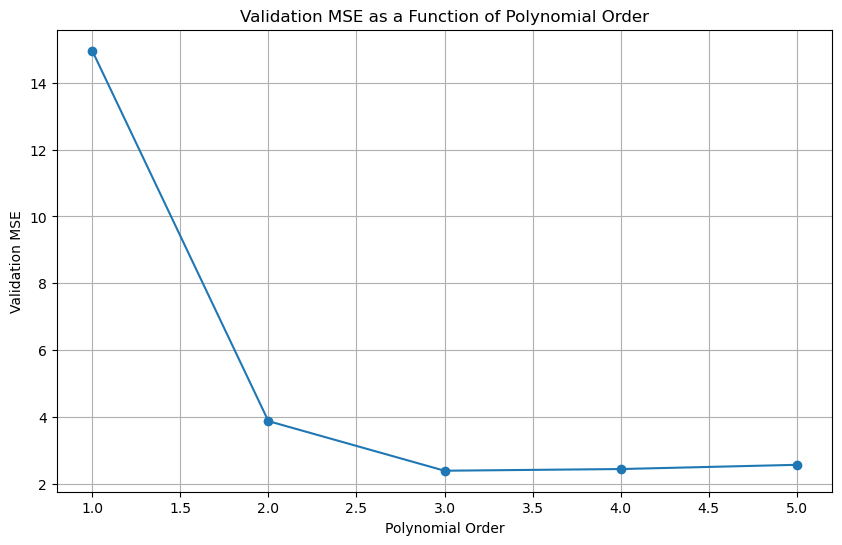


Bias-Variance Analysis:
Polynomial Order 1: Validation MSE = 14.97
Polynomial Order 2: Validation MSE = 3.87
Polynomial Order 3: Validation MSE = 2.38
Polynomial Order 4: Validation MSE = 2.43
Polynomial Order 5: Validation MSE = 2.56


In [9]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the polynomial orders to be tested
polynomial_orders = [1, 2, 3, 4, 5]

# Create a pipeline that includes polynomial features and linear regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {'poly__degree': polynomial_orders}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train.ravel()) 

# Report the best parameters and the corresponding performance
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Evaluate the performance on the independent test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test set mean squared error (MSE):", test_mse)

# Plot the learning curve
validation_scores = -grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(polynomial_orders, validation_scores, marker='o')
plt.title('Validation MSE as a Function of Polynomial Order')
plt.xlabel('Polynomial Order')
plt.ylabel('Validation MSE')
plt.grid(True)
plt.show()

# Bias-Variance Analysis
print("\nBias-Variance Analysis:")
for degree, score in zip(polynomial_orders, validation_scores):
    print(f"Polynomial Order {degree}: Validation MSE = {score:.2f}")

Best parameters: {'poly__degree': 1}
Best cross-validation score (negative MSE): -3143.0153074277246
Test set mean squared error (MSE): 2900.193628493481


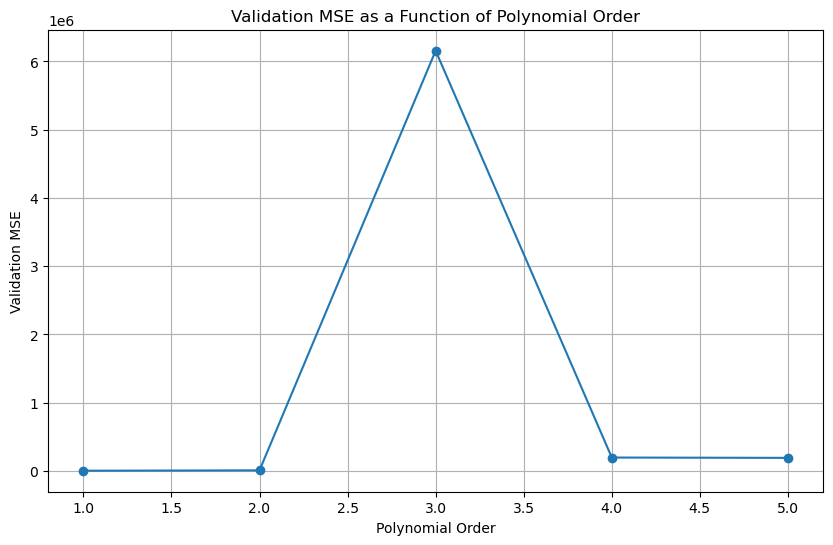


Bias-Variance Analysis:
Polynomial Order 1: Validation MSE = 3143.02
Polynomial Order 2: Validation MSE = 8509.24
Polynomial Order 3: Validation MSE = 6156847.71
Polynomial Order 4: Validation MSE = 196320.22
Polynomial Order 5: Validation MSE = 191529.74


In [10]:
# Load the diabetes dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the polynomial orders to be tested
polynomial_orders = [1, 2, 3, 4, 5]

# Create a pipeline that includes polynomial features and linear regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])

# Define the parameter grid for GridSearchCV
param_grid = {'poly__degree': polynomial_orders}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Report the best parameters and the corresponding performance
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

# Evaluate the performance on the independent test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test set mean squared error (MSE):", test_mse)

# Plot the learning curve
validation_scores = -grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(polynomial_orders, validation_scores, marker='o')
plt.title('Validation MSE as a Function of Polynomial Order')
plt.xlabel('Polynomial Order')
plt.ylabel('Validation MSE')
plt.grid(True)
plt.show()

# Bias-Variance Analysis
print("\nBias-Variance Analysis:")
for degree, score in zip(polynomial_orders, validation_scores):
    print(f"Polynomial Order {degree}: Validation MSE = {score:.2f}")

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

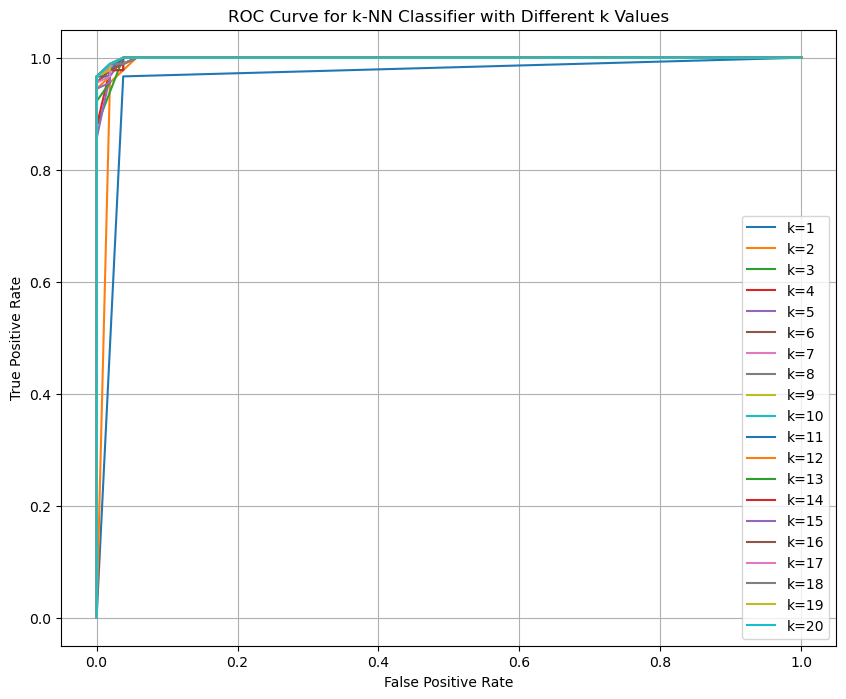

In [11]:
X = breast_cancer.data
y = breast_cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# Define the range of k values to evaluate
k_values = range(1, 21)
fprs = []
tprs = []

# Evaluate the classifier for different values of k
for k in k_values:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities for the test set
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    fprs.append(fpr)
    tprs.append(tpr)

# Plot ROC curves for different values of k
plt.figure(figsize=(10, 8))
for i, k in enumerate(k_values):
    plt.plot(fprs[i], tprs[i], label=f'k={k}')

plt.title('ROC Curve for k-NN Classifier with Different k Values')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


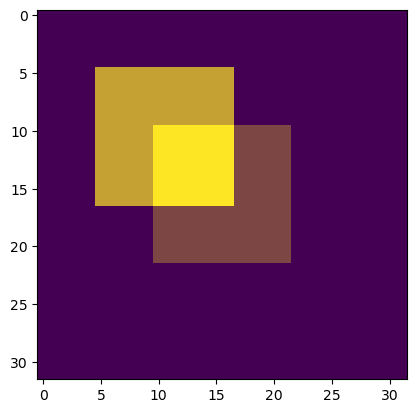

In [12]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

**Definitions in words:**

- **True Positives (tp):** The number of elements correctly identified as positive.
- **False Positives (fp):** The number of elements incorrectly identified as positive.
- **False Negatives (fn):** The number of elements incorrectly identified as negative.

Given two sets $A$ and $B$:

- $tp = |A \cap B|$
- $fp = |B \setminus A|$
- $fn = |A \setminus B|$
- $|A| = |A \cap B| + |A \setminus B|$
- $|B| = |A \cap B| + |B \setminus A|$

**F₁ Score Formula:**

The $F_1$ score, which is the harmonic mean of precision and recall, is defined as:

$$
F_1 = \frac{2 \cdot tp}{2 \cdot tp + fp + fn}
$$

Substituting the equations above:

$$
F_1 = \frac{2 |A \cap B|}{2 |A \cap B| + |B \setminus A| + |A \setminus B|}
$$

**Simplifying the Denominator:**

Using:

$$
2 |A \cap B| + |B \setminus A| + |A \setminus B| = |A| + |B|
$$

Because:

$$
|A| + |B| = (|A \cap B| + |A \setminus B|) + (|A \cap B| + |B \setminus A|) = 2 |A \cap B| + |A \setminus B| + |B \setminus A|
$$

**Dice Similarity Coefficient Formula:**

The Dice coefficient is defined as:

$$
\text{Dice}(A, B) = \frac{2 |A \cap B|}{|A| + |B|}
$$

**Conclusion:**

Since the denominators are equal after simplification, we have:

$$
F_1 = \text{Dice}(A, B) = \frac{2 |A \cap B|}{|A| + |B|}
$$

**So, the $F_1$ score is equivalent to the Dice similarity coefficient.**